<a href="https://colab.research.google.com/github/talkin24/jaxflax_lab/blob/main/Unet_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q flax

In [2]:
import jax
from jax import lax, random, numpy as jnp

import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state

import optax

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import functools
from typing import Any, Callable, Sequence, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt


In [386]:
class DoubleConvBR(nn.Module):
  out_dim: int

  # Conv Parameters
  kernel_size: Tuple[int, int] = (3, 3)
  strides: int = 1
  padding: int = 0
  
  # BatchNorm Parameters
  use_running_average: bool = False
  momentum: float = 0.9
  epsilon: float = 1e-5
  dtype: jnp.dtype = jnp.float32

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=self.out_dim, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)(x)
    # x = nn.BatchNorm(use_running_average=self.use_running_average, momentum=self.momentum, epsilon = self.epsilon, dtype = self.dtype)(x) 
    x = nn.relu(x)
    x = nn.Conv(features=self.out_dim, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)(x)
    # x = nn.BatchNorm(use_running_average=self.use_running_average, momentum=self.momentum, epsilon = self.epsilon, dtype = self.dtype)(x) 
    x = nn.relu(x)
    return x


class Down(nn.Module):
  out_dim: int
  
  # max_pool Parameters
  window_shape: Tuple[int, int] = (2, 2)
  strides: Tuple[int, int] = (2, 2)

  @nn.compact
  def __call__(self, x):
    x = nn.max_pool(x, window_shape=self.window_shape, strides=self.strides)
    x = DoubleConvBR(self.out_dim)(x)
    return x


class Up(nn.Module):
  out_dim: int
  
  # ConvTranspose Parameters
  kernel_size: Tuple[int, int] = (2, 2)
  strides: Tuple[int, int] = (2, 2)
  padding: int = 1
 
  @nn.compact
  def __call__(self, x):
    x = nn.ConvTranspose(features=self.out_dim * 2, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)(x)
    x = DoubleConvBR(self.out_dim)(x)
    return x


class Unet(nn.Module):
  n_classes: int = 1
  

  @nn.compact
  def __call__(self, x):

  # Contracting path
    x = DoubleConvBR(64)(x)
    x = Down(128)(x)
    x = Down(256)(x)
    x = Down(512)(x)
    x = Down(1024)(x)

  # Expansive path
    x = Up(512)(x)
    x = Up(256)(x)
    x = Up(128)(x)
    x = Up(64)(x)
    
    x = nn.Dense(self.n_classes)(x)
    return x


In [410]:
unet = Unet()
print(unet.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 286, 286, 3))))


                                  Unet Summary                                  
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs       ┃ params       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│               │ Unet          │ float32[1,28… │ float32[1,10… │              │
├───────────────┼───────────────┼───────────────┼───────────────┼──────────────┤
│ DoubleConvBR… │ DoubleConvBR  │ float32[1,28… │ float32[1,28… │              │
├───────────────┼───────────────┼───────────────┼───────────────┼──────────────┤
│ DoubleConvBR… │ Conv          │ float32[1,28… │ float32[1,28… │ bias:        │
│               │               │               │               │ float32[64]  │
│               │               │               │               │ kernel:      │
│               │               │               │               │ float32[3,3… │
│               │          

In [411]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [389]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [431]:
def load_image(datapoint):
  # input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_image = tf.image.resize(datapoint['image'], (286, 286))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    # (128, 128),
    (100, 100),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [432]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [434]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [435]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [436]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

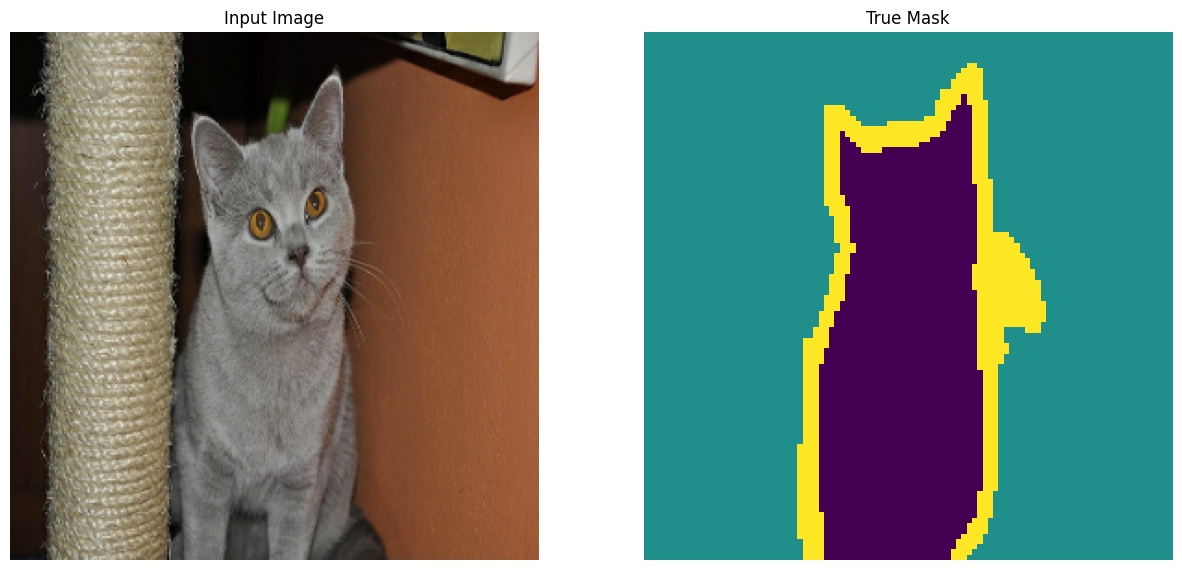

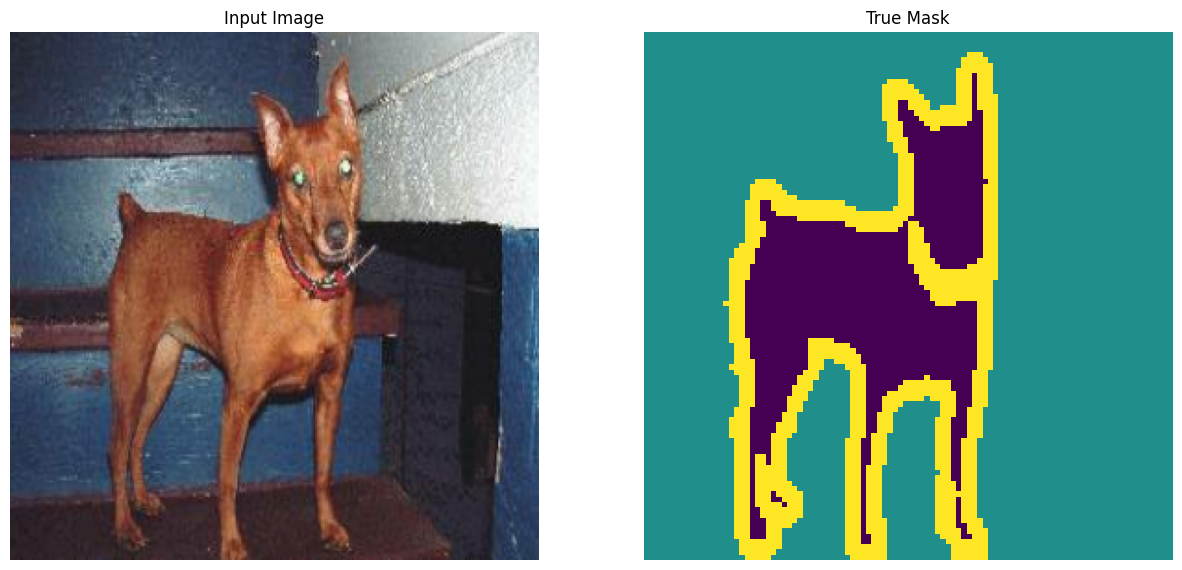

In [437]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [438]:
!pip install -q clu

In [439]:
from clu import metrics
from flax.training import train_state  
from flax import struct                
import optax 

In [440]:
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

In [441]:
class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
  params = module.init(rng, jnp.ones([1, 286, 286, 3]))['params']
  tx = optax.adam(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty()
  )

In [512]:
@jax.jit
def train_step(state, batch):
  def loss_fn(params):
    logits = state.apply_fn({'params': state.params}, batch[0])
    loss = optax.softmax_cross_entropy(
        logits=logits, labels=batch[1]).mean()
    return loss

  # grad_fn = jax.grad(loss_fn)
  loss, grads = jax.value_and_grad(loss_fn)(state.params)
  state = state.apply_gradients(grads=grads)
  return state, loss

In [503]:
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch[0])
  loss = optax.softmax_cross_entropy(
      logits=logits, labels=batch[1]).mean()
  metric_updates = state.metrics.single_from_model_output(
      logits=logits, labels=batch[1][:, :, :, -1], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

In [504]:
tf.random.set_seed(0)

In [505]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01
momentum = 0.9

state = create_train_state(unet, init_rng, learning_rate, momentum)
del init_rng

In [506]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [507]:
XLA_PYTHON_CLIENT_PREALLOCATE=False

In [508]:
num_epochs = 10
batch_size = 32

In [514]:
for step, batch in enumerate(train_batches.as_numpy_iterator()):

  state, train_loss = train_step(state, batch)
  # state = compute_metrics(state=state, batch=batch)

  if (step+1) % STEPS_PER_EPOCH == 0:
    # for metric,value in state.metrics.compute().items(): 
    #   metrics_history[f'train_{metric}'].append(value) 
    # state = state.replace(metrics=state.metrics.empty())

    # test_state = state
    # for test_batch in test_batches.as_numpy_iterator():
    #   test_state = compute_metrics(state=test_state, batch=test_batch)

    # for metric,value in test_state.metrics.compute().items():
    #   metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // STEPS_PER_EPOCH}, "
          f"loss: {train_loss} ")
          # f"loss: {metrics_history['train_loss'][-1]}, "
          # f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    # print(f"test epoch: {(step+1) // STEPS_PER_EPOCH}, "
    #       f"loss: {metrics_history['test_loss'][-1]}, "
    #       f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.0 
train epoch: 2, loss: 0.0 
train epoch: 3, loss: 0.0 
train epoch: 4, loss: 0.0 


KeyboardInterrupt: ignored